In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [4]:
data = pd.read_csv('datasets/creditcard/creditcard.csv')
data.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Text(0, 0.5, 'Frequent')

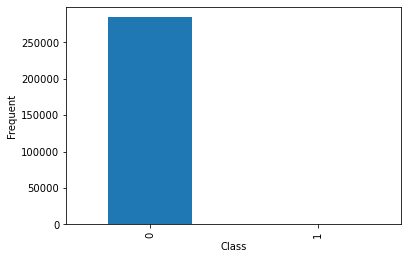

In [5]:
Class_count = pd.value_counts(data['Class'],sort=True,).sort_index()
Class_count.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Frequent')

In [6]:
#异常数量
errorNum = len(data[data.Class == 1])
print(errorNum)
#异常索引
errorArrIndex = np.array(data[data.Class == 1].index)
errorArrIndex

492


array([   541,    623,   4920,   6108,   6329,   6331,   6334,   6336,
         6338,   6427,   6446,   6472,   6529,   6609,   6641,   6717,
         6719,   6734,   6774,   6820,   6870,   6882,   6899,   6903,
         6971,   8296,   8312,   8335,   8615,   8617,   8842,   8845,
         8972,   9035,   9179,   9252,   9487,   9509,  10204,  10484,
        10497,  10498,  10568,  10630,  10690,  10801,  10891,  10897,
        11343,  11710,  11841,  11880,  12070,  12108,  12261,  12369,
        14104,  14170,  14197,  14211,  14338,  15166,  15204,  15225,
        15451,  15476,  15506,  15539,  15566,  15736,  15751,  15781,
        15810,  16415,  16780,  16863,  17317,  17366,  17407,  17453,
        17480,  18466,  18472,  18773,  18809,  20198,  23308,  23422,
        26802,  27362,  27627,  27738,  27749,  29687,  30100,  30314,
        30384,  30398,  30442,  30473,  30496,  31002,  33276,  39183,
        40085,  40525,  41395,  41569,  41943,  42007,  42009,  42473,
      

In [7]:
#标准化
from sklearn.preprocessing import StandardScaler
data['newAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))
data = data.drop(['Time','Amount'],axis=1)

In [8]:
#下采样——正常数向下匹配异常数
#正常数索引
normalArrIndexAll = np.array(data[data.Class == 0].index)
#根据异常数随机从正常中获取相同数量的索引
normalArrIndex = np.random.choice(normalArrIndexAll, errorNum, replace=False)
normalArrIndex = np.array(normalArrIndex)

#整合索引
underIndex = np.concatenate([normalArrIndex,errorArrIndex])
#获取所有采取点
underSample = data.iloc[underIndex,:]
#print(underSample)
#两类所占比例
print('sample:',len(underSample[underSample.Class==0]))
print('error:',len(underSample[underSample.Class==1]))

sample: 492
error: 492


In [9]:
#交叉验证——数据集划分成多个训练集与测试集一起，每次取一个做验证集，之后多个验证集取平均得到结果
#获取特征——删除Class列
X = data.iloc[:,lambda df : data.columns != 'Class']
X_sample = underSample.iloc[:,lambda df : underSample.columns != 'Class']

#标签
y = data.iloc[:,lambda df : data.columns == 'Class']
y_sample = underSample.iloc[:,lambda df : underSample.columns == 'Class']

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.3, random_state=0)
print('原始训练集包含样本数',len(X_train))
print('原始测试集包含样本数',len(X_test))

X_sample_train,X_sample_test,y_sample_train,y_sample_test = train_test_split(X_sample,y_sample,test_size=.3, random_state=0)
print('原始训练集包含样本数',len(X_sample_train))
print('原始测试集包含样本数',len(X_sample_test))

原始训练集包含样本数 199364
原始测试集包含样本数 85443
原始训练集包含样本数 688
原始测试集包含样本数 296


In [16]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score

#建模
def printing_Kfold_scores(x_train_data,y_train_data):
    fold = KFold(5,shuffle=False)
    #正则化惩罚力度
    c_param_range = [.01, .1, 1, 10, 100]
    #展示
    res_table = pd.DataFrame(index=range(len(c_param_range),2), columns=['C_parameter','Mean recall score'])
    res_table['C_parameter'] = c_param_range
    #k_fold返回训练集indices[0]和验证集indices[1]
    j = 0
    for c_param in c_param_range:
        print('----------------')
        print('正则化惩罚力度：',c_param)
        print('----------------')
        print('')
        recall_accs = []

        for iteration, indices in enumerate(fold.split(y_train_data),start=1):
            #算法模型
            lr = LogisticRegression(C=c_param,penalty='l2',solver='lbfgs',max_iter=3000)
            #训练模型
            lr.fit(x_train_data.iloc[indices[0],:],y_train_data.iloc[indices[0],:].values.ravel())
            #预测
            y_pred_undersample = lr.predict(x_train_data.iloc[indices[1],:].values)
            #recall评估
            recall_acc = recall_score(y_train_data.iloc[indices[1],:].values, y_pred_undersample)
            #放入列表最后求平均值
            recall_accs.append(recall_acc)
            print('Iteration ',iteration,': 召回率 = ',recall_acc)
        res_table.loc[j,'Mean recall score'] = np.mean(recall_accs)
        j+=1
        print("")
        print('平均召回率 ',np.mean(recall_accs))
        print('')
    best_c = res_table.loc[res_table['Mean recall score'].astype('float32').idxmax()]['C_parameter']

    print('------------------------')
    print('best parameter = ',best_c)
    print('------------------------')
    return best_c
best_c = printing_Kfold_scores(X_sample_train,y_sample_train)

----------------
正则化惩罚力度： 0.01
----------------

Iteration  1 : 召回率 =  0.9230769230769231
Iteration  2 : 召回率 =  0.8615384615384616
Iteration  3 : 召回率 =  0.8227848101265823
Iteration  4 : 召回率 =  0.9206349206349206
Iteration  5 : 召回率 =  0.8873239436619719

平均召回率  0.883071811807772

----------------
正则化惩罚力度： 0.1
----------------

Iteration  1 : 召回率 =  0.9230769230769231
Iteration  2 : 召回率 =  0.8923076923076924
Iteration  3 : 召回率 =  0.8481012658227848
Iteration  4 : 召回率 =  0.9365079365079365
Iteration  5 : 召回率 =  0.9295774647887324

平均召回率  0.9059142565008138

----------------
正则化惩罚力度： 1
----------------

Iteration  1 : 召回率 =  0.9230769230769231
Iteration  2 : 召回率 =  0.8923076923076924
Iteration  3 : 召回率 =  0.8227848101265823
Iteration  4 : 召回率 =  0.9365079365079365
Iteration  5 : 召回率 =  0.9295774647887324

平均召回率  0.9008509653615733

----------------
正则化惩罚力度： 10
----------------

Iteration  1 : 召回率 =  0.9384615384615385
Iteration  2 : 召回率 =  0.8769230769230769
Iteration  3 : 召回率 =  0.835443

In [11]:
from sklearn.metrics import plot_confusion_matrix

